In [1]:
# python -m spacy download en
import spacy 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os 
import fitz
from threading import Thread
import re
import networkx as nx
import community.community_louvain as community_louvain
from pyvis.network import Network


spa = spacy.load('en_core_web_sm')


C:\Users\ahmed\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
NovelBooks = {"A Game of Therones":[16,909],"A Clash of Kings":[960,1851],"A Storm of Swords":[1904,3042],
              "A Feast for Crows":[3104,3901],"A Dance with Dragons":[3988,5109]}
FitzBook = fitz.open('./books/complete-a-song-of-ice-and-fire---george-r-r-martin.pdf')
books_dict_df={}
relation_dict_df={}

In [3]:
#for making sure the person is real person in the novel we did scraping game of theron wiki and get all characters in the novel 
# we will  compare result of ner with scraping result 
df_char = pd.read_csv('characters.csv')

In [4]:
def spacey_entities(book,FitzBook,saveToDict=1):
    '''
    book : tuble contain name of book as key and value is list contain start and end page 
    FitzBook : fitz book  contain pages to read
    output : return pandas data frame contian sentances and it's entities
    each sentance has at least 150 char reading page by page
    '''
    print(f"start {book[0]}")
    sentances = []
    text= ""
    for i in range(book[1][0],book[1][1]+1) :
        pag = re.sub("”",'''”,''' ,FitzBook[i].get_text())
        spacy_doc= spa(pag)
        for sent in spacy_doc.sents :
            
            if len(sent.text) > 150 and text !="":
                sentances.append(sent)
                
            else :
                text= text+sent.text

            if len(text)>150:
                sentances.append(spa(text))
                text= ""
    entities =[[entity.text for entity in sent.ents if entity.label_ not in['CARDINAL','DATE','TIME','QUANTITY','WORK_OF_ART']] for sent in sentances ]
    print(f"end {book[0]}")
    if saveToDict :
        books_dict_df[book[0]]=pd.DataFrame(data={"sentence":sentances,'entities':entities})
        return
    return pd.DataFrame(data={"sentence":sentances,'entities':entities})

def spacey_entities_all_books(NovelBooks,FitzBook):
    '''
    book : dictaionary contain name of book as key and value is list contain start and end page 
    FitzBook : fitz book  contain pages to read
    output : return dict of book name and pandas data frame contian sentances and it's entities
    each sentance has at least 150 char reading page by page
    '''
    # books_dict_df = {}
    threads= []
    for book in NovelBooks.items() :
    #    books_dict_df[book[0]]=
        threads.append(Thread(target= spacey_entities,args=(book,FitzBook)))
    #    spacey_entities(book,FitzBook)
    for th in threads:
        th.start()
    
    for th in threads:
        th.join()
    return
    # return books_dict_df

def filter_character(row):
# the
# ser
#prince joffrey’s	
#somtime characters referd by first name only and sometime other refer by full name
    ll=[]
    for el in row:
        if re.sub("’[a-zA-Z]","",el.split(" ")[0].lower()) not in ["ser","prince","lady","lord","king","house","first"] :
            if re.sub("’[a-zA-Z]","",el.split(" ")[0].lower())  in df_char.firstName.values:
                ll.append(re.sub("’[a-zA-Z]","",el.split(" ")[0].lower()))
        elif len(el.split(" "))>1:
            if re.sub("’[a-zA-Z]","",el.split(" ")[1].lower())  in df_char.firstName.values:
                ll.append(re.sub("’[a-zA-Z]","","".join(el.lower().split(" ")[1])))
    return ll


def create_relationDF(frame,df_name=''):
    relation_list=[]
    for i in range(0,frame.shape[0]):
        relation_list.extend(frame["character"].iloc[i])
    src_list=[]
    des_list = []
    for i in range(len(relation_list)):
        if(i%2 ==0):
            src_list.append(relation_list[i])
        else:
            des_list.append(relation_list[i])

    if len(src_list) > len(des_list):
        src_list.pop()
    elif len(src_list) < len(des_list):
        des_list.pop()

    relation_df = pd.DataFrame({"src":src_list,"des":des_list})
    # drop self relationsthip : gared gared
    print("count of self relationship : ",relation_df[relation_df["src"]==relation_df["des"]].shape[0])
    relation_df.drop(relation_df[relation_df["src"]==relation_df["des"]].index,inplace=True)

    # a :b = b:a
    relation_df = pd.DataFrame( np.sort(relation_df.values,axis=1),columns=["src","des"])

    # for use in groubing
    relation_df['value']= 1
    relation_df = relation_df.groupby(by=["src","des"],sort=False,as_index=False).sum().sort_values("value",ascending=False)
    if df_name == '':
        return relation_df
    else :
       relation_dict_df[df_name] = relation_df

def concat_all_dataframes(books_dict_df):
    df = pd.concat(list(books_dict_df.values()))
    return df

def save_dataframe():
    for book in books_dict_df:
        books_dict_df[book].to_csv(os.path.join('dataframes',book+'.csv'),index=False)
def save_relation_dataframe():
    for book in relation_dict_df:
        relation_dict_df[book].to_csv(os.path.join('dataframes',book+'_relation_.csv'),index=False)

def read_dataframe():
    for book in NovelBooks:
        books_dict_df[book]=pd.read_csv(f"./dataframes/{book}.csv")
        relation_dict_df[book]=pd.read_csv(f"./dataframes/{book}_relation_.csv")

In [5]:
spacey_entities_all_books(NovelBooks,FitzBook)

start A Game of Therones
start A Clash of Kings
start A Storm of Swords
start A Feast for Crows
start A Dance with Dragons
end A Game of Therones
end A Feast for Crows
end A Clash of Kings
end A Dance with Dragons
end A Storm of Swords


In [5]:
##read data
read_dataframe()

In [7]:
df1 = books_dict_df["A Game of Therones"]
print(df1.info())
df1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4682 entries, 0 to 4681
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   4682 non-null   object
 1   entities   4682 non-null   object
 2   character  4682 non-null   object
dtypes: object(3)
memory usage: 109.9+ KB
None


,sentence,entities,character
0,"PROLOGUE\n“We should start back,”, Gared urged...","['Gared', 'Ser Waymar Royce']","['gared', 'waymar']"
1,Gared did not rise to the bait.He was an old m...,['Royce'],['royce']
2,"“What proof have we?”,\n“Will saw them,”, Gare...",['Gared'],['gared']
3,He wished it had been later rather than sooner...,['Royce'],['royce']
4,"“We have a long ride before us,”, Gared pointe...",['Gared'],['gared']
...,...,...,...
4677,When the �re died at last and the ground becam...,['Ser Jorah Mormont'],['jorah']
4678,"When it saw Jorah, it raised its\nhead and loo...","['Jorah', 'Wordless']",['jorah']
4679,Jhogo was the �rst to lay his arakh at her fee...,['Jhogo'],['jhogo']
4680,"“Blood of my\nblood,”, Rakharo shouted.\nAnd a...","['Rakharo', 'Dany']",['rakharo']


# analysis sentences to improve character output

In [8]:
df1["sentence"].loc[6]

'Mounted on his huge black\ndestrier, the knight towered above Will and Gared on their smaller\ngarrons.Ser Waymar had been\na Sworn Brother of the Night’s Watch for less than half a year, but\nno one could say he had not prepared for his vocation.'

In [8]:
from spacy import displacy
displacy.render(spa("“Fallen,” Will insisted. “There’s one woman up an ironwood, halfhid in the branches. A far-eyes.” He smiled thinly. “I took care she never saw me. When I got closer, I saw that she wasn’t moving neither.” Despite himself, he shivered.\n“You have a chill?”, Royce asked., “Some,” Will muttered.,“The wind, m’lord.” "),style='ent')
doc= '''“You have a chill?”, Royce asked.'''
displacy.render(spa(doc),style='ent')
#add comma after each ” 
#make each sentace more than 150 character
#not all entity are charcters in the story 

# organize the data

In [9]:

for frame in books_dict_df.values():
    #drop rows has no entiteies
    frame.drop(index=frame[frame["entities"].str.len()==0].index,inplace=True)
    # filter entiteies for only characters
    frame['character']= frame['entities'].apply(filter_character)
    #drop rows has no character
    frame.drop(index=frame[frame["character"].str.len()==0].index,inplace=True)

list(books_dict_df.values())[0]

,sentence,entities,character
0,"(PROLOGUE, \n, “, We, should, start, back, ,, ...","[Gared, Ser Waymar Royce]","[gared, waymar]"
1,"(Gared, did, not, rise, to, the, bait, ., He, ...",[Royce],[royce]
2,"(“, What, proof, have, we, ?, ”, ,, \n, “, Wil...",[Gared],[gared]
3,"(He, wished, it, had, been, later, rather, tha...",[Royce],[royce]
5,"(“, We, have, a, long, ride, before, us, ,, ”,...",[Gared],[gared]
...,...,...,...
8101,"(When, the, �, re, died, at, last, and, the, g...",[Ser Jorah Mormont],[jorah]
8104,"(When, it, saw, Jorah, ,, it, raised, its, \n,...","[Jorah, Wordless]",[jorah]
8105,"(Jhogo, was, the, �, rst, to, lay, his, arakh,...",[Jhogo],[jhogo]
8106,"(“, Blood, of, my, \n, blood, ,, ”, ,, Rakharo...","[Rakharo, Dany]",[rakharo]


In [10]:
for book in NovelBooks:
   create_relationDF(books_dict_df[book],book)

count of self relationship :  622
count of self relationship :  546
count of self relationship :  793
count of self relationship :  548
count of self relationship :  695


In [11]:
relation_df1 = relation_dict_df["A Game of Therones"]
print(relation_df1.info())
relation_df1

<class 'pandas.core.frame.DataFrame'>
Index: 1255 entries, 34 to 1254
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   src     1255 non-null   object
 1   des     1255 non-null   object
 2   value   1255 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 39.2+ KB
None


,src,des,value
34,ned,robert,143
79,arya,sansa,47
26,catelyn,ned,42
390,jon,sam,35
277,jon,mormont,31
...,...,...,...
579,jon,stone,1
581,nestor,tyrion,1
582,moon,royce,1
586,lyn,mya,1


In [29]:
save_dataframe()
save_relation_dataframe()

In [ ]:
G = nx.from_pandas_edgelist(relation_dict_df["whole"][:500],source="src",target="des",edge_attr="value")

# graph analysis and visualization

In [165]:
graphs = {}
for book in NovelBooks:
    
    G = nx.from_pandas_edgelist(relation_dict_df[book][:400],source="src",target="des",edge_attr="value")
    
    graphs[book]=nx.degree_centrality(G)#pd.DataFrame.from_dict(nx.degree_centrality(G),orient='index',columns=['degree']).sort_values(by=['degree'],ascending=False)
    pd.DataFrame.from_dict(nx.degree_centrality(G),orient='index',columns=['degree']).sort_values(by=['degree'],ascending=False).to_csv(os.path.join('dataframes',book+'_degree' +'.csv'))

    net = Network(notebook=True,width= "1920px",height="1024px",bgcolor='black',font_color="white",cdn_resources='remote')

    edges_num =dict(G.degree)
    nx.set_node_attributes(G,edges_num,"size")
    nx.set_node_attributes(G,community_louvain.best_partition(G),"group")
    net.from_nx(G)
    net.save_graph(f"graphs/{book}.html")#.show("book.html")

<AxesSubplot:>

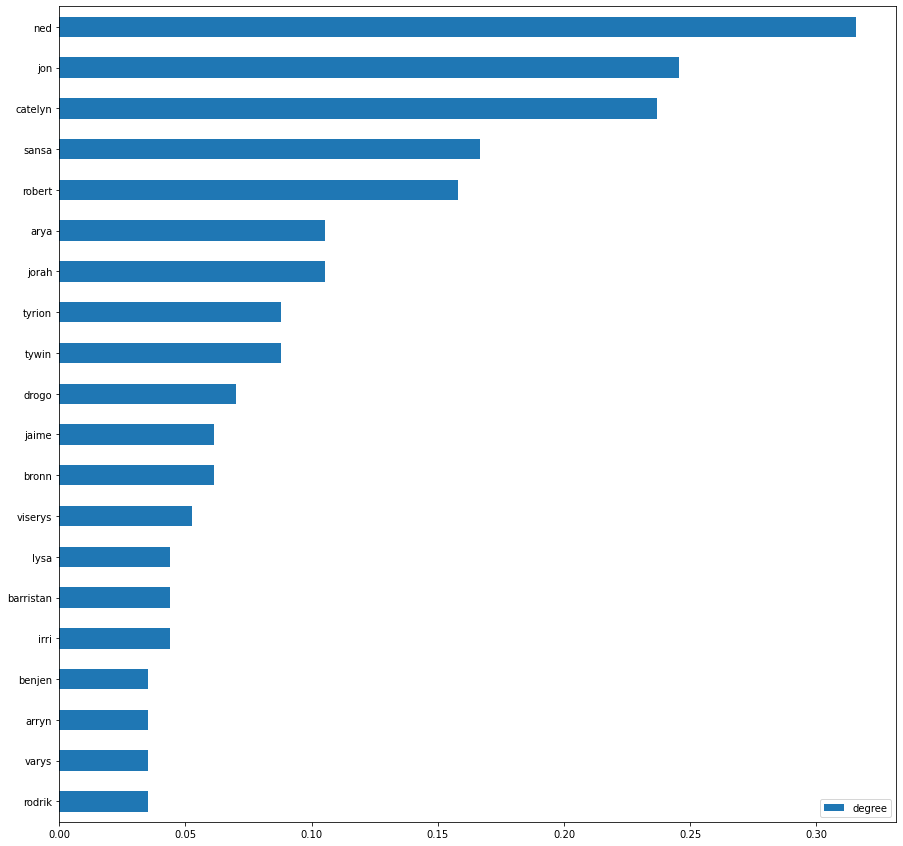

In [16]:
# nx.degree_centrality(G)
pd.DataFrame.from_dict(nx.degree_centrality(G),orient='index',columns=['degree']).sort_values(by="degree",ascending=True).iloc[-20:].plot(kind="barh",figsize=(15,15))

In [17]:
sorted(edges_num.items(),key=lambda item:item[1],reverse=True)

[('ned', 36),
 ('jon', 28),
 ('catelyn', 27),
 ('sansa', 19),
 ('robert', 18),
 ('arya', 12),
 ('jorah', 12),
 ('tyrion', 10),
 ('tywin', 10),
 ('drogo', 8),
 ('bronn', 7),
 ('jaime', 7),
 ('viserys', 6),
 ('lysa', 5),
 ('barristan', 5),
 ('irri', 5),
 ('sam', 4),
 ('rodrik', 4),
 ('benjen', 4),
 ('varys', 4),
 ('illyrio', 4),
 ('pycelle', 4),
 ('mirri', 4),
 ('qotho', 4),
 ('jhiqui', 4),
 ('arryn', 4),
 ('jhogo', 4),
 ('vardis', 3),
 ('cersei', 3),
 ('renly', 3),
 ('rhaegar', 3),
 ('eddard', 3),
 ('gregor', 3),
 ('rickon', 3),
 ('petyr', 3),
 ('aerys', 3),
 ('daenerys', 3),
 ('stannis', 3),
 ('frey', 3),
 ('walder', 3),
 ('moreo', 3),
 ('mormont', 2),
 ('grenn', 2),
 ('alliser', 2),
 ('samwell', 2),
 ('nymeria', 2),
 ('halder', 2),
 ('jeyne', 2),
 ('sandor', 2),
 ('lyanna', 2),
 ('brandon', 2),
 ('loras', 2),
 ('gared', 2),
 ('royce', 2),
 ('luwin', 2),
 ('mycah', 2),
 ('grey', 2),
 ('theon', 2),
 ('yoren', 2),
 ('shagga', 2),
 ('mord', 2),
 ('old', 2),
 ('jaremy', 2),
 ('janos', 2),


In [ ]:
##graph for each book / 
##graph for all books
## most dominate character for each book
##most dominate for all books
##charactedr domination through books



# join all books together

In [52]:
df = concat_all_dataframes(books_dict_df)
df["character"]=df["character"].map(lambda x :re.sub("'","",re.sub(' ','',x[1:-1])).split(','))
df["entities"]=df["entities"].map(lambda x :re.sub("'","",re.sub(' ','',x[1:-1])).split(','))

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26951 entries, 0 to 5761
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   26951 non-null  object
 1   entities   26951 non-null  object
 2   character  26951 non-null  object
dtypes: object(3)
memory usage: 842.2+ KB


In [58]:
# relations_df =[]
create_relationDF(df,"whole")

count of self relationship :  3204


In [162]:
df.to_csv(os.path.join('dataframes',"wholebook"+'.csv'),index=False)
relation_dict_df["whole"].to_csv(os.path.join('dataframes',"wholebook"+'_relation_.csv'),index=False)

In [68]:

relation_dict_df["whole"][:10]

,src,des,value
34,ned,robert,159
390,jon,sam,125
2431,brienne,jaime,99
2387,jon,ygritte,80
1766,jojen,meera,72
2812,jon,tormund,67
1484,arya,gendry,66
277,jon,mormont,64
411,jon,stannis,63
1399,jon,qhorin,62


In [77]:
G = nx.from_pandas_edgelist(relation_dict_df["whole"][:500],source="src",target="des",edge_attr="value")


In [78]:
nx.degree_centrality(G)

{'ned': 0.09375,
 'robert': 0.1015625,
 'jon': 0.22265625,
 'sam': 0.0703125,
 'brienne': 0.0703125,
 'jaime': 0.1640625,
 'ygritte': 0.015625,
 'jojen': 0.01171875,
 'meera': 0.0078125,
 'tormund': 0.0078125,
 'arya': 0.11328125,
 'gendry': 0.03125,
 'mormont': 0.015625,
 'stannis': 0.11328125,
 'qhorin': 0.00390625,
 'sansa': 0.10546875,
 'grenn': 0.015625,
 'catelyn': 0.12109375,
 'hodor': 0.0234375,
 'davos': 0.05859375,
 'mance': 0.01171875,
 'melisandre': 0.02734375,
 'gilly': 0.01171875,
 'satin': 0.00390625,
 'bowen': 0.0078125,
 'cersei': 0.06640625,
 'tywin': 0.08203125,
 'barristan': 0.05078125,
 'hizdahr': 0.01953125,
 'podrick': 0.01171875,
 'euron': 0.015625,
 'victarion': 0.0234375,
 'gerris': 0.01171875,
 'quentyn': 0.0234375,
 'renly': 0.03125,
 'craster': 0.015625,
 'alliser': 0.00390625,
 'syrio': 0.00390625,
 'yoren': 0.015625,
 'irri': 0.0078125,
 'jhiqui': 0.01171875,
 'bronn': 0.03125,
 'tyrion': 0.0703125,
 'jorah': 0.0703125,
 'viserys': 0.01953125,
 'petyr': 0

In [167]:
#save degree dataframe
pd.DataFrame.from_dict(nx.degree_centrality(G),orient='index',columns=['degree']).sort_values(by="degree",ascending=False).to_csv(os.path.join('dataframes','wholebook_degree' +'.csv'))

# degree Accross wholebook

In [156]:
track_character = ['ned','jon','catelyn','sansa','robert','arya' , 'jorah','tyrion','tywin','jaime','bronn','stannis','brienne','cersei','sam','daenerys','ygritte' ]
track_character_degree = {}
for tc in track_character:
    track_character_degree[tc]=[]

for graph in graphs:
    for ch in track_character : #graphs[graph]:
        if ch in graphs[graph] :
            track_character_degree[ch].append(graphs[graph][ch])
        else :
            track_character_degree[ch].append(0)

track_character_degree = pd.DataFrame.from_dict(track_character_degree)
track_character_degree.rename(index={0:'got',1:'COK',2:'SOS',3:'FFC',4:'DWD'},inplace=True)
track_character_degree

In [168]:
track_character_degree.to_csv(os.path.join('dataframes','degreeAccrosswholebook.csv'))

<AxesSubplot:>

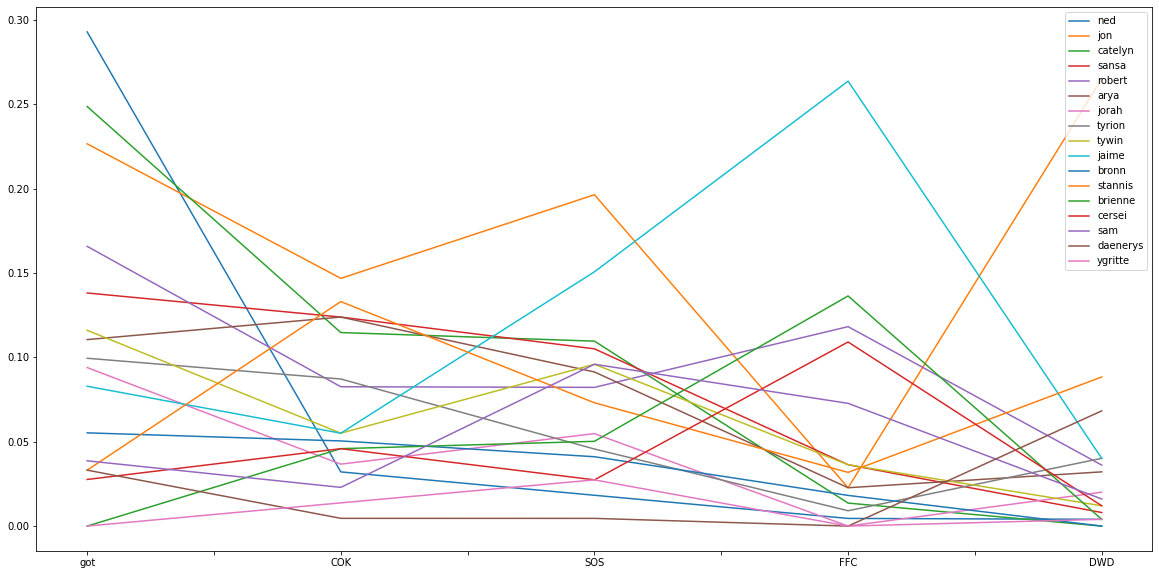

In [161]:
track_character_degree.plot(kind='line',figsize=(20,10))